## XGBoost Model on Diff Data
USA World Series Results,
Run on "Diff" data

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
%matplotlib inline

In [8]:
#Import Data - only want USA matches
df = pd.read_csv("../data/output/new_features_diffdata.csv")
df.head()

,Opp,Tournament,Poss_Time_Diff,Score_Diff,Conv_Diff,Tries_Diff,Passes_Diff,Contestable_KO_Win_pct_Diff,PenFK_Against_Diff,RuckMaul_Diff,...,-99 : -75,-74 : -25,-24 : -1,0 : 25,26 : 50,51 : 75,76 : 100,101 : 125,126 : 150,Result
0,AUSTRALIA,2015_Cape_Town,13.966480,-10.638298,-14.285714,0.250000,25.925926,-50.000000,0.000000,0.000000,...,0.0,-12.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,WALES,2015_Cape_Town,7.471264,15.555556,14.285714,0.083333,27.868852,25.000000,-20.000000,-100.000000,...,0.0,0.0,0.0,12.5,0.0,0.0,0.0,0.0,0.0,1
2,KENYA,2015_Cape_Town,-33.136095,-44.444444,-33.333333,-0.750000,-10.638298,-16.666667,66.666667,60.000000,...,0.0,0.0,-5.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,NEW ZEALAND,2015_Cape_Town,51.758794,33.333333,33.333333,0.000000,76.119403,-75.000000,-50.000000,-100.000000,...,-37.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,FIJI,2015_Cape_Town,12.880562,-20.833333,-25.000000,0.266667,38.461538,-66.666667,-33.333333,-33.333333,...,0.0,-12.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [9]:
df.info()
list(df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 27 columns):
Opp                            156 non-null object
Tournament                     156 non-null object
Poss_Time_Diff                 156 non-null float64
Score_Diff                     156 non-null float64
Conv_Diff                      156 non-null float64
Tries_Diff                     156 non-null float64
Passes_Diff                    156 non-null float64
Contestable_KO_Win_pct_Diff    156 non-null float64
PenFK_Against_Diff             156 non-null float64
RuckMaul_Diff                  156 non-null float64
Ruck_Win_pct_Diff              156 non-null float64
Cards_diff                     156 non-null float64
Lineout_Win_Pct_Diff           156 non-null float64
Scrum_Win_Pct_Diff             156 non-null float64
-175 : -150                    156 non-null float64
-149 : -125                    156 non-null float64
-124 : -100                    156 non-null float64
-99 : -75    

['Opp',
 'Tournament',
 'Poss_Time_Diff',
 'Score_Diff',
 'Conv_Diff',
 'Tries_Diff',
 'Passes_Diff',
 'Contestable_KO_Win_pct_Diff',
 'PenFK_Against_Diff',
 'RuckMaul_Diff',
 'Ruck_Win_pct_Diff',
 'Cards_diff',
 'Lineout_Win_Pct_Diff',
 'Scrum_Win_Pct_Diff',
 '-175 : -150',
 '-149 : -125',
 '-124 : -100',
 '-99 : -75',
 '-74 : -25',
 '-24 : -1',
 '0 : 25',
 '26 : 50',
 '51 : 75',
 '76 : 100',
 '101 : 125',
 '126 : 150',
 'Result']

In [10]:
#Create a list of features to drop that are unneccessary or will bias the prediction
droplist = ['Opp', 'Score_Diff', 'Tries_Diff','Tournament', 'Conv_Diff','-175 : -150', '-149 : -125','-124 : -100', '-99 : -75', '-74 : -25','-24 : -1','0 : 25','26 : 50','51 : 75','76 : 100','101 : 125','126 : 150']

xg_data = df.drop((droplist), axis=1)

#Drop rows with Result == "T" (Ties). This label messes up classification models
xg_data.drop(xg_data[xg_data.Result == 2].index, inplace=True)

#Pull out the variable we're trying to predict: 'Result'
X = xg_data.drop('Result',axis=1)
y = xg_data['Result']

In [11]:
xg_data.head()
#Check to insure 'Result' only contains 2 values (W, L)
xg_data['Result'].describe()
xg_data.describe()

,Poss_Time_Diff,Passes_Diff,Contestable_KO_Win_pct_Diff,PenFK_Against_Diff,RuckMaul_Diff,Ruck_Win_pct_Diff,Cards_diff,Lineout_Win_Pct_Diff,Scrum_Win_Pct_Diff,Result
count,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000
mean,10.402130,17.196314,2.491328,-1.993963,-0.644381,0.062044,5.298013,0.124614,-0.081126,0.562914
std,20.750082,26.935639,45.526240,49.889728,59.542377,0.198595,27.780280,0.668788,0.637047,0.497677
min,-40.000000,-48.837209,-166.666667,-100.000000,-100.000000,-0.550000,-50.000000,-1.000000,-1.000000,0.000000
25%,-3.491112,0.793651,-27.500000,-33.333333,-33.333333,-0.083333,0.000000,0.000000,-0.500000,0.000000
50%,11.166253,16.129032,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,1.000000
75%,23.795151,34.495192,33.333333,33.333333,33.333333,0.181187,0.000000,0.750000,0.000000,1.000000
max,72.272727,90.909091,133.333333,100.000000,100.000000,0.875000,100.000000,1.000000,1.000000,1.000000


In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=143)

In [16]:
#import the neccessary libraries
import xgboost
from xgboost.sklearn import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from xgboost import plot_importance
from matplotlib import pyplot
import pprint
%matplotlib inline

In [17]:
# Create a pipeline
pipeline = Pipeline([('scaler', StandardScaler()), ('classifier', XGBClassifier())])

In [18]:
# See the default parameters of the stages in our pipeline
pipeline

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [19]:
#Once we have our pipeline with XGBoost classifier is set up, we can train it by invoking fit method.
pipeline.fit(X_train.values, y_train.values)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

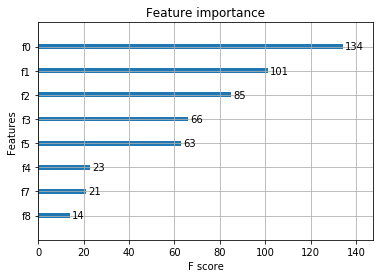

In [20]:
xgboost.plot_importance(pipeline.steps[1][1])

In [21]:
#Make predictions on test data and evaluate the model
y_pred = pipeline.predict(X_test.values)

In [22]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 54.35%


We can tune our model now to achieve better accuracy by using grid search and cross validation.

XGBoost hyperparameters:

learning_rate (default=0.1): Boosting learning rate (xgb’s “eta”).  
n_estimators (default=100): Number of boosted trees to fit.  
max_depth (default=3): Maximum tree depth for base learners.  
objective (default='binary:logistic'): Specify the learning task and the corresponding learning objective or a custom objective function to be used.  

In [23]:
#Create our XGBoost pipeline and setup parameter space.

pipeline_gs = Pipeline([('scaler', StandardScaler()), ('classifier', XGBClassifier())])
parameters = {'classifier__learning_rate': [0.01, 0.03], 'classifier__n_estimators': [50, 200]}

In [25]:
# Search for the best parameters with GridSearchCV. 
# You can use estimator.get_params().keys() to see the available hyperparameters for search.

from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(pipeline_gs, parameters)

In [26]:
clf.fit(X_train.values, y_train.values)

/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child...       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'classifier__learning_rate': [0.01, 0.03], 'classifier__n_estimators': [50, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [34]:
#See the performance result of all parameter combinations including the best parameter combination 
#based on model performance from grid search scores

clf.cv_results_

/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/admin/anaconda3/lib/pyth

{'mean_fit_time': array([0.00911999, 0.02239116, 0.00535727, 0.02154072]),
 'std_fit_time': array([1.54628495e-03, 3.10490369e-03, 2.57433190e-05, 3.16432705e-04]),
 'mean_score_time': array([0.00093492, 0.00089614, 0.00050926, 0.00144498]),
 'std_score_time': array([1.67956408e-04, 1.82184281e-04, 1.24891289e-05, 1.13082870e-04]),
 'param_classifier__learning_rate': masked_array(data=[0.01, 0.01, 0.03, 0.03],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_classifier__n_estimators': masked_array(data=[50, 200, 50, 200],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'classifier__learning_rate': 0.01,
   'classifier__n_estimators': 50},
  {'classifier__learning_rate': 0.01, 'classifier__n_estimators': 200},
  {'classifier__learning_rate': 0.03, 'classifier__n_estimators': 50},
  {'classifier__learning_rate': 0.03, 'classifier__n_estimators': 200}],
 'split0_te

In [31]:
# Best score and parameter set
print("Best score: %s" % (clf.best_score_))
print("Best parameter set: %s" % (clf.best_params_))

Best score: 0.6285714285714286
Best parameter set: {'classifier__learning_rate': 0.03, 'classifier__n_estimators': 50}


In [35]:
#Get the accuracy of best parameter combination on test set.

y_pred = clf.predict(X_test.values)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 39.13%
